In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../PYTORCH_NOTEBOOKS/Data', train = True, download = True, transform = transform)

In [4]:
test_data = datasets.MNIST(root='../PYTORCH_NOTEBOOKS/Data', train = False, download = True, transform = transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../PYTORCH_NOTEBOOKS/Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../PYTORCH_NOTEBOOKS/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

In [8]:
test_loader = DataLoader(test_data, batch_size = 500, shuffle=False)

In [9]:
for images,labels in train_loader:
    break

In [10]:
labels.shape

torch.Size([100])

In [11]:
import matplotlib.pyplot as plt
import numpy as np

labels: [2 9 6 5 7 6 8 6 1 5]


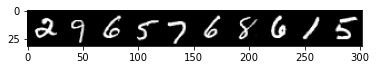

In [12]:
print("labels:", labels[:10].numpy())

im = make_grid(images[:10], nrow=10)
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

In [24]:
class CNNmnist(nn.Module):
    def __init__(self,in_sz,out_sz,layers):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)  #-->color channel-->no_of filters-->image karnel-->stride
        self.conv2 = nn.Conv2d(6,16,3,1) #-->input from conv1-->no_of filters-->image karnel-->stride
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,16*5*5) #flatten out the data---> 16(input feature) * (((28-2)/2)-2)/2((image-karnel)pixel size after pooling)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x,dim=1)

In [25]:
torch.manual_seed(42)
model = CNNmnist(in_sz=16*5*5,out_sz=10,layers=[120,84])

In [26]:
model

CNNmnist(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [28]:
lost_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
import time 
start_time = time.time()

train_loss = []
test_loss = []
train_correct = []
test_correct = []

epochs = 5
for i in range(epochs):
    
    trn_corr = 0
    test_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(X_train)
        loss = lost_function(y_pred, y_train)
        
        predicted = torch.max(y_pred.data,axis = 1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            accuracy = trn_corr.item()/b
            print(f'epochs:{i} batch:{b} loss:{loss.item()} accuracy:{accuracy}')
            
    train_loss.append(loss)
    train_correct.append(trn_corr)
    
    #validation part:
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            y_val = model(X_test)
            
            predicted = torch.max(y_val.data,axis = 1)[1]
            batch_corr = (predicted==y_test).sum()
            test_corr += batch_corr
            
    loss1 = lost_function(y_val, y_test)
    test_loss.append(loss1)
    test_correct.append(test_corr)

total_time = time.time() - start_time
print(f"Duration: {total_time/60} mins")

epochs:0 batch:200 loss:0.4877311587333679 accuracy:76.465
epochs:0 batch:400 loss:0.23414082825183868 accuracy:84.27
epochs:0 batch:600 loss:0.20488505065441132 accuracy:87.79666666666667
epochs:1 batch:200 loss:0.08856142312288284 accuracy:95.76
epochs:1 batch:400 loss:0.10095831751823425 accuracy:96.245
epochs:1 batch:600 loss:0.01958644762635231 accuracy:96.46333333333334
epochs:2 batch:200 loss:0.03228691965341568 accuracy:97.305
epochs:2 batch:400 loss:0.033680789172649384 accuracy:97.4275
epochs:2 batch:600 loss:0.016389384865760803 accuracy:97.605
epochs:3 batch:200 loss:0.0803612545132637 accuracy:98.055
epochs:3 batch:400 loss:0.021365361288189888 accuracy:98.01
epochs:3 batch:600 loss:0.11589983105659485 accuracy:98.12833333333333
epochs:4 batch:200 loss:0.03189205750823021 accuracy:98.335
epochs:4 batch:400 loss:0.057859212160110474 accuracy:98.3975
epochs:4 batch:600 loss:0.012299677357077599 accuracy:98.43
Duration: 3.6342819730440774 mins


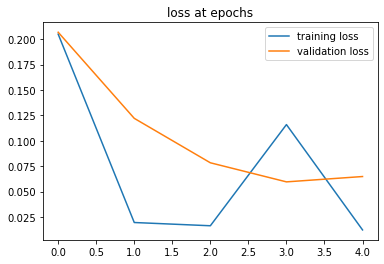

In [30]:
plt.plot(train_loss, label='training loss')
plt.plot(test_loss, label='validation loss')
plt.title('loss at epochs')
plt.legend()

In [32]:
train_acc = [training_data/600 for training_data in train_correct]
test_acc = [testing_data/100 for testing_data in test_correct]

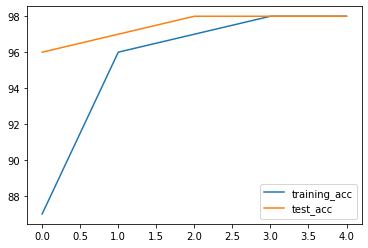

In [33]:
plt.plot(train_acc,label='training_acc')
plt.plot(test_acc,label='test_acc')
plt.legend()

In [34]:
test_load_all = DataLoader(test_data,batch_size=10000,shuffle=True)

In [35]:
with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted==y_test).sum()

In [36]:
correct.item()

9841

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
print(confusion_matrix(predicted.view(-1),y_test.view(-1)))

[[ 975    0    3    0    1    2    7    0    7    1]
 [   0 1133    6    0    0    1    2    3    0    2]
 [   1    0 1012    1    0    0    0    9    3    2]
 [   0    0    3 1004    0   11    0    5   13    2]
 [   0    0    1    0  967    0    3    0    2    4]
 [   1    0    0    2    0  873    4    0    4    1]
 [   1    1    0    0    2    2  942    0    0    0]
 [   1    0    4    1    1    1    0 1005    2    3]
 [   0    1    3    1    1    0    0    1  937    1]
 [   1    0    0    1   10    2    0    5    6  993]]


In [39]:
data = test_data[2019][0].reshape(28,28)

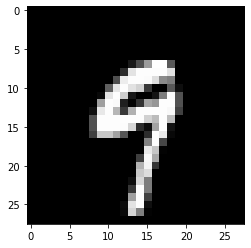

In [48]:
plt.imshow(data, cmap='gray')

In [42]:
model.eval()
with torch.no_grad():
    new_pred = model(data.view(1,1,28,28))

In [43]:
new_pred.argmax()

tensor(9)